In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
df_rel = pd.read_csv("/kaggle/input/reliance/reliance.csv")
df_hdfc = pd.read_csv("/kaggle/input/hdfc-bank/hdfc.csv")

In [9]:
def visualize_price_time(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Open'])
    plt.title('Open Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Open')
    plt.show()

In [10]:
Scale=StandardScaler()

def data_prep(df, lookback, future, Scale):
    df = df.drop(index=0)
    df = df.drop(index=1)
    
    df = df.reset_index(drop=True)
    # Drop the last column
    df = df.drop(columns=df.columns[-1])
    df = df.rename(columns={'Price': 'Date'})

    df['Date'] = pd.to_datetime(df['Date'])
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')

    df.head()
    visualize_price_time(df)

    date_train = pd.to_datetime(df['Date'])
    df_train = df[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_train = df_train.astype(float)
    
    df_train_scaled = Scale.fit_transform(df_train)

    X, y = [], []
    for i in range(lookback, len(df_train_scaled) - future + 1):
        X.append(df_train_scaled[i - lookback:i, 0:df_train.shape[1]])
        y.append(df_train_scaled[i + future - 1:i + future, 0])

    X = np.array(X)  # Convert list of arrays to a single NumPy array
    y = np.array(y)  # Convert list of arrays to a single NumPy array

    # Convert the lists to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    return X_tensor, y_tensor, df_train, date_train, df

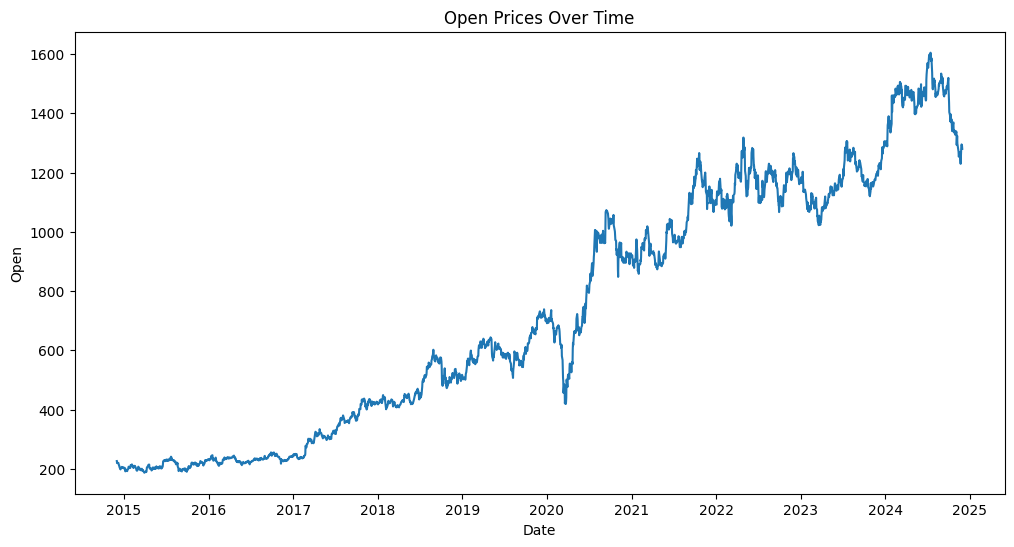

In [11]:
X, y, df_train, date_train, df = data_prep(df_rel, 30, 1, Scale)

In [12]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=50, num_layers=8):
        super(LSTMRegressor, self).__init__()
        
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        # First LSTM layer
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim, batch_first=True))
        self.dropout_layers.append(nn.Dropout(0.2))
        
        # Additional LSTM layers
        for _ in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_dim, hidden_dim, batch_first=True))
            self.dropout_layers.append(nn.Dropout(0.2))
        
        # Final dense layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
            x, _ = lstm(x)
            x = dropout(x)
        
        # Use the last time step
        x = self.fc(x[:, -1, :])
        return x

In [13]:
import torch
import torch.nn as nn

class ImprovedLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout_rate=0.2, 
                 learning_rate=0.001, bidirectional=True):
        super(ImprovedLSTMRegressor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.num_directions = 2 if bidirectional else 1
        
        # Create a more sophisticated LSTM stack
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Adaptive pooling to handle variable sequence lengths
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Output layer with adaptive dimensionality
        output_dim = hidden_dim * self.num_directions
        self.fc = nn.Sequential(
            nn.Linear(output_dim, output_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(output_dim // 2, 1)
        )
        
        # Optional: Weight initialization
        self.apply(self._init_weights)
        
        self.learning_rate = learning_rate
    
    def _init_weights(self, module):
        """
        Custom weight initialization to improve training stability
        """
        if isinstance(module, nn.Linear):
            # Initialize linear layer weights
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            # Initialize LSTM weights
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)
    
    def forward(self, x):
        # Ensure input is 3D (batch, sequence, features)
        if x.dim() == 2:
            x = x.unsqueeze(0)
        
        # LSTM forward pass with automatic hidden state management
        lstm_out, _ = self.lstm(x)
        
        # Handle bidirectional output
        if self.bidirectional:
            # Concatenate forward and backward last states
            forward_out = lstm_out[:, -1, :self.hidden_dim]
            backward_out = lstm_out[:, 0, self.hidden_dim:]
            combined_out = torch.cat([forward_out, backward_out], dim=-1)
        else:
            combined_out = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        output = self.fc(combined_out)
        
        return output
    
    def reset_parameters(self):
        """
        Method to reset model parameters if needed
        """
        self.apply(self._init_weights)

In [14]:
def train_lstm_model(X, y, val_split=0.2, epochs=200, batch_size=64, learning_rate=0.001):
    """
    Train the LSTM Regressor model with advanced training techniques.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Input features (sequence data)
    y : numpy.ndarray
        Target values
    val_split : float, optional (default=0.2)
        Proportion of data to use for validation
    epochs : int, optional (default=200)
        Maximum number of training epochs
    batch_size : int, optional (default=64)
        Batch size for training
    learning_rate : float, optional (default=0.001)
        Initial learning rate
    
    Returns:
    --------
    tuple : (trained model, validation features, validation targets)
    """
    # Determine device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    
    # Ensure X is 3D (samples, timesteps, features)
    if len(X.shape) < 3:
        X = X.reshape(X.shape[0], 1, -1)
    
    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Split into train and validation sets
    val_size = int(len(X_tensor) * val_split)
    train_size = len(X_tensor) - val_size
    
    X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss, and optimizer
    model = ImprovedLSTMRegressor(input_dim=X.shape[2], num_layers=4).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    patience = 20
    counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x).squeeze()
                loss = criterion(outputs, batch_y.squeeze())
                val_loss += loss.item()
        
        # Average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Print epoch results
        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')
        
        #Early stopping
        # if avg_val_loss < best_val_loss:
        #     best_val_loss = avg_val_loss
        #     counter = 0
        #     best_model_state = model.state_dict().copy()
        # else:
        #     counter += 1
            
        #     if counter >= patience:
        #         print(f'Early stopping triggered after {epoch+1} epochs')
        #         model.load_state_dict(best_model_state)
        #         break
    
    # Return model, validation features, and validation targets
    return model, X_val.cpu().numpy(), y_val.cpu().numpy()

In [64]:
model, X_val, y_val = train_lstm_model(X, y)

Training on device: cuda


/tmp/ipykernel_23/2279441117.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
/tmp/ipykernel_23/2279441117.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 0.2450, Val Loss = 0.4291
Epoch 2: Train Loss = 0.0298, Val Loss = 0.1657
Epoch 3: Train Loss = 0.0179, Val Loss = 0.0896
Epoch 4: Train Loss = 0.0168, Val Loss = 0.0589
Epoch 5: Train Loss = 0.0138, Val Loss = 0.0651
Epoch 6: Train Loss = 0.0130, Val Loss = 0.0337
Epoch 7: Train Loss = 0.0142, Val Loss = 0.0141
Epoch 8: Train Loss = 0.0120, Val Loss = 0.0189
Epoch 9: Train Loss = 0.0116, Val Loss = 0.0099
Epoch 10: Train Loss = 0.0116, Val Loss = 0.0453
Epoch 11: Train Loss = 0.0123, Val Loss = 0.0123
Epoch 12: Train Loss = 0.0120, Val Loss = 0.0560
Epoch 13: Train Loss = 0.0111, Val Loss = 0.0139
Epoch 14: Train Loss = 0.0107, Val Loss = 0.0304
Epoch 15: Train Loss = 0.0100, Val Loss = 0.0226
Epoch 16: Train Loss = 0.0119, Val Loss = 0.0267
Epoch 17: Train Loss = 0.0114, Val Loss = 0.0150
Epoch 18: Train Loss = 0.0105, Val Loss = 0.0115
Epoch 19: Train Loss = 0.0103, Val Loss = 0.0090
Epoch 20: Train Loss = 0.0107, Val Loss = 0.0108
Epoch 21: Train Loss = 0.0107

In [15]:
def compare_val_predictions(model, X_val, y_val, scaler=None):
    """
    Robust prediction comparison with comprehensive error handling
    """
    # Debug print to understand input shapes
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)
    print("Scaler type:", type(scaler))
    
    # Defensive shape handling
    y_val_reshaped = y_val.reshape(-1, 1) if y_val.ndim == 1 else y_val
    
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Ensure input is 3D
    if len(X_val.shape) < 3:
        X_val = X_val.reshape(X_val.shape[0], 1, -1)
    
    # Convert to tensor
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor).cpu().numpy().flatten()
    
    # Comprehensive scaling handling
    if scaler is not None:
        try:
            # Ensure that only the 'open' column is being inverse transformed
            if not hasattr(scaler, 'mean_'):
                raise ValueError("Scaler has not been fitted. Use scaler.fit_transform() before inverse_transform().")
            
            # Assuming scaler is fitted on the 'open' column
            actual = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
            pred = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            
        except ValueError as e:
            print(f"Scaling error: {e}")
            print("Falling back to unscaled values")
            actual = y_val
            pred = predictions
        
        
    else:
        actual = y_val
        pred = predictions
    
    # Rest of the function remains the same...
    # (metrics calculation, plotting, etc.)
    
    # Calculate performance metrics
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(pred, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Validation Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Target Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Mean Squared Error', 'Mean Absolute Error', 'R² Score'],
        'Value': [mse, mae, r2]
    })
    
    return {
        'predictions': pred,
        'actual': actual,
        'metrics': metrics_df
    }


In [16]:
scaler = StandardScaler()
y_val_scaled = scaler.fit_transform(y_val.reshape(-1, 1))

NameError: name 'y_val' is not defined

X_val shape: (487, 30, 6)
y_val shape: (487, 1)
Scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>


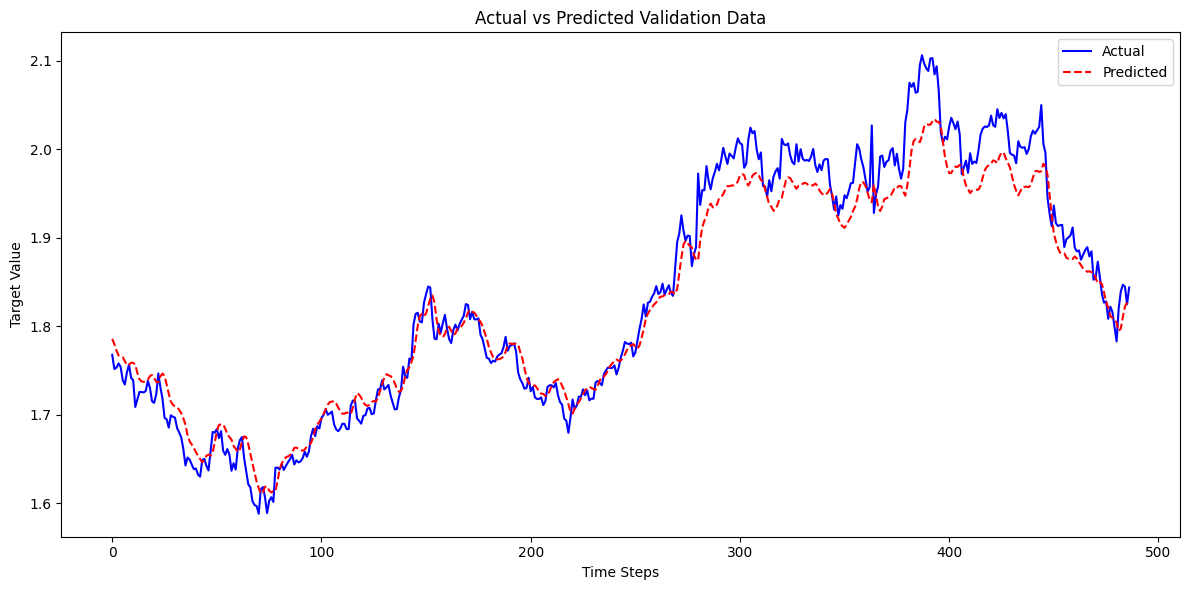

                Metric     Value
0   Mean Squared Error  0.000866
1  Mean Absolute Error  0.022872
2             R² Score  0.954209


In [30]:
result = compare_val_predictions(model, X_val, y_val, scaler)
print(result['metrics'])

In [17]:
def prepare_prediction_inputs(
    df,  # Your original DataFrame
    scaler,  # StandardScaler used during data preparation
    sequence_length=30
):
    """
    Prepare the last sequence for prediction
    """
    # Select columns used during scaling
    columns = ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']
    last_sequence = df[columns].iloc[-sequence_length:].astype(float)
    
    # Transform using the same scaler
    scaled_sequence = scaler.transform(last_sequence)
    
    return scaled_sequence

In [18]:
def generate_6_month_predictions(
    model,
    name,
    df,  # Original DataFrame
    scaler_open,
    sequence_length=30
):
    """
    Generate predictions for all dates over the next 6 months.
    """
    # Prepare input sequence
    last_sequence = prepare_prediction_inputs(
        df, 
        scaler_open, 
        sequence_length
    )
    
    # Generate daily predictions for 6 months
    predictions = predict_future_stock_prices(
        model, 
        last_sequence, 
        scaler_open,
        target_column_index=1,  # Index for 'Open' column
        num_days=180  # Approximately 6 months (30 days x 6)
    )
    
    # Get the last date and generate future dates for every day
    last_date = pd.to_datetime(df['Date'].iloc[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(predictions), freq='D')
    
    # Create final DataFrame with dates and predictions
    predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Open': predictions['Predicted_Open']
    })
    
    # Visualization
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(predictions_df['Date'], predictions_df['Open'], label='Predicted Open Prices', color='blue')
    plt.title('6-Month Open Price Predictions (Daily)')
    plt.xlabel('Date')
    plt.ylabel('Predicted Open Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    # Save predictions to CSV
    predictions_df.to_csv(f'6_month_{name}_stock_predictions_daily.csv', index=False)
    
    return predictions_df


def predict_future_stock_prices(
    model, 
    last_data, 
    scaler, 
    num_days=180,  # Predict daily prices for 6 months
    target_column_index=1  # Default to 'Open' column
):
    """
    Generate future stock price predictions for all dates in the next 6 months.
    """
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    if last_data.ndim == 2:
        last_data = last_data.reshape(1, *last_data.shape)
    
    current_sequence = torch.tensor(last_data, dtype=torch.float32).to(device)
    
    future_predictions = []
    
    with torch.no_grad():
        for _ in range(num_days):
            # Get next prediction
            next_pred = model(current_sequence).cpu().numpy()
            next_pred = next_pred.item()
            
            # Create a full-width array for inverse transform
            full_pred = np.zeros((1, 6))  # Assume 6 features in the scaler
            full_pred[0, target_column_index] = next_pred
            
            # Inverse transform prediction
            unscaled_pred = scaler.inverse_transform(full_pred)[0, target_column_index]
            future_predictions.append(unscaled_pred)
            
            # Prepare next sequence
            next_sequence = np.roll(current_sequence.cpu().numpy(), -1, axis=1)
            next_sequence[0, -1, target_column_index] = next_pred
            
            current_sequence = torch.tensor(next_sequence, dtype=torch.float32).to(device)
    
    # Create DataFrame
    predictions_df = pd.DataFrame({
        'Predicted_Open': future_predictions
    })
    
    return predictions_df


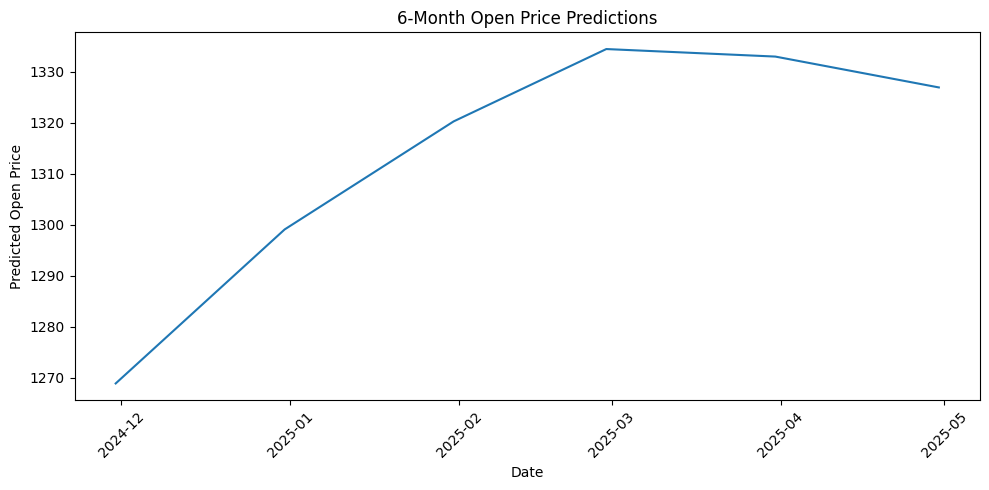

,Date,Open
0,2024-11-30,1268.847553
1,2024-12-31,1299.077013
2,2025-01-31,1320.278140
3,2025-02-28,1334.474280
4,2025-03-31,1332.998866
5,2025-04-30,1326.941702


In [88]:
generate_6_month_predictions(
    model, 
    "reliance",
    df,  # Original DataFrame
    Scale,
    sequence_length=30
)

In [89]:
df_hdfc = pd.read_csv("/kaggle/input/hdfc-bank/hdfc.csv")

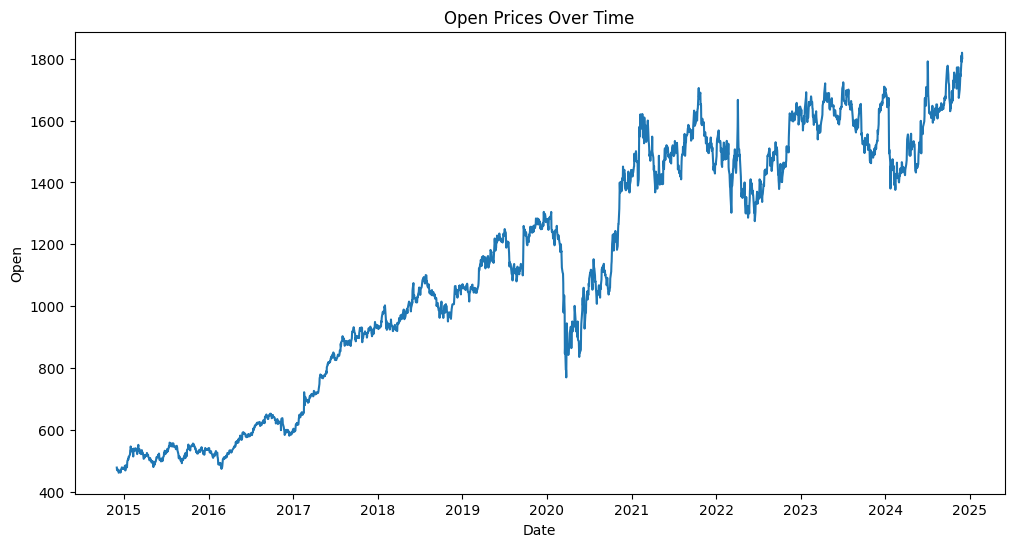

In [90]:
X, y, df_train, date_train, df = data_prep(df_hdfc, 30, 1, Scale)

In [102]:
model, X_val, y_val = train_lstm_model(X, y)

Training on device: cuda


/tmp/ipykernel_23/2985912243.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
/tmp/ipykernel_23/2985912243.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 0.2782, Val Loss = 0.2030
Epoch 2: Train Loss = 0.0346, Val Loss = 0.1021
Epoch 3: Train Loss = 0.0237, Val Loss = 0.0945
Epoch 4: Train Loss = 0.0191, Val Loss = 0.0565
Epoch 5: Train Loss = 0.0171, Val Loss = 0.0893
Epoch 6: Train Loss = 0.0171, Val Loss = 0.0730
Epoch 7: Train Loss = 0.0165, Val Loss = 0.0324
Epoch 8: Train Loss = 0.0145, Val Loss = 0.0465
Epoch 9: Train Loss = 0.0141, Val Loss = 0.0403
Epoch 10: Train Loss = 0.0134, Val Loss = 0.0401
Epoch 11: Train Loss = 0.0139, Val Loss = 0.0209
Epoch 12: Train Loss = 0.0128, Val Loss = 0.0206
Epoch 13: Train Loss = 0.0122, Val Loss = 0.0290
Epoch 14: Train Loss = 0.0142, Val Loss = 0.0778
Epoch 15: Train Loss = 0.0140, Val Loss = 0.0448
Epoch 16: Train Loss = 0.0124, Val Loss = 0.0377
Epoch 17: Train Loss = 0.0133, Val Loss = 0.0286
Epoch 18: Train Loss = 0.0117, Val Loss = 0.0640
Epoch 19: Train Loss = 0.0122, Val Loss = 0.0718
Epoch 20: Train Loss = 0.0134, Val Loss = 0.0605
Epoch 21: Train Loss = 0.0110

In [103]:
y_val_scaled = scaler.fit_transform(y_val.reshape(-1, 1))

X_val shape: (487, 30, 6)
y_val shape: (487, 1)
Scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>


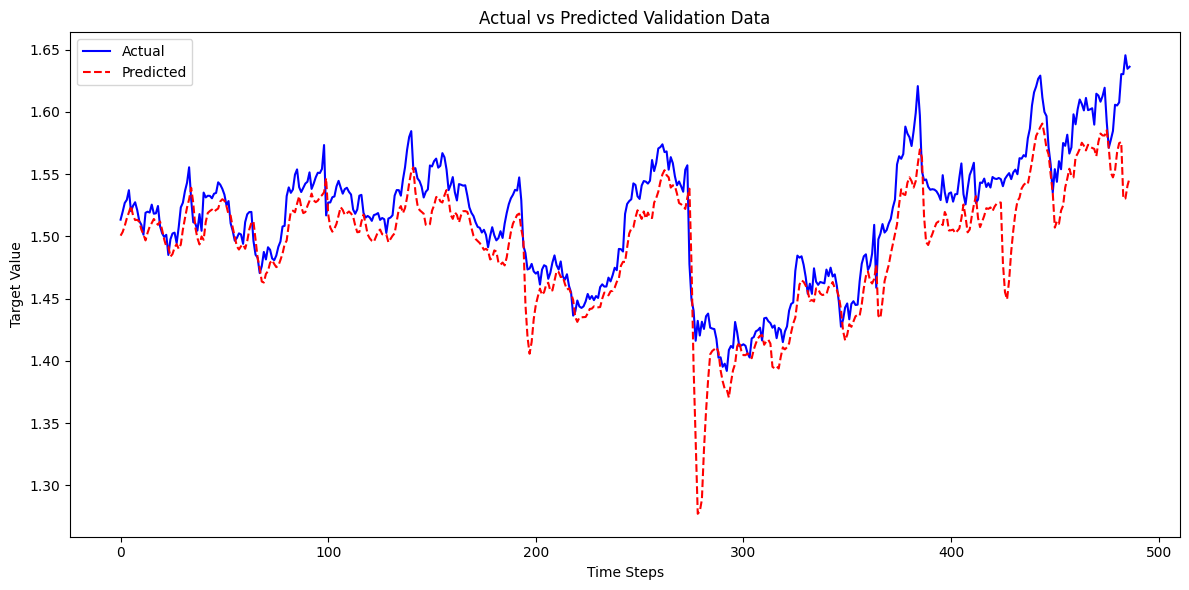

                Metric     Value
0   Mean Squared Error  0.000918
1  Mean Absolute Error  0.023213
2             R² Score  0.655235


In [104]:
result = compare_val_predictions(model, X_val, y_val, scaler)
print(result['metrics'])

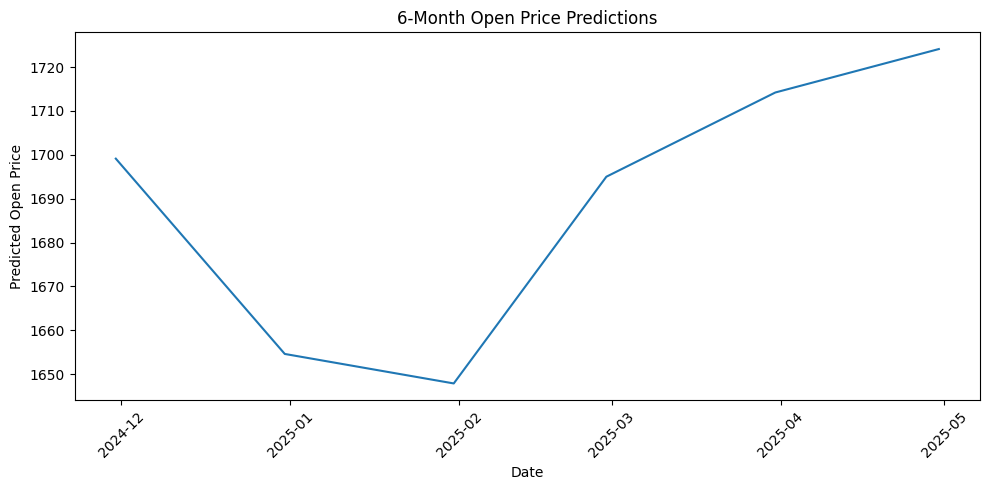

,Date,Open
0,2024-11-30,1699.124195
1,2024-12-31,1654.608741
2,2025-01-31,1647.884292
3,2025-02-28,1695.004269
4,2025-03-31,1714.201529
5,2025-04-30,1724.101965


In [105]:
generate_6_month_predictions(
    model, 
    "hdfc",
    df,  # Original DataFrame
    Scale,
    sequence_length=30
)

In [19]:
df_bharat = "/kaggle/input/bharat/bharat.csv"

In [20]:
def main(path, name):
    df = pd.read_csv(path)
    X, y, df_train, date_train, df = data_prep(df, 30, 1, Scale)
    model, X_val, y_val = train_lstm_model(X, y)
    scaler = StandardScaler()
    y_val_scaled = scaler.fit_transform(y_val.reshape(-1, 1))
    result = compare_val_predictions(model, X_val, y_val, scaler)
    print(result['metrics'])
    generate_6_month_predictions(
        model, 
        name,
        df,  # Original DataFrame
        Scale,
        sequence_length=30
    )

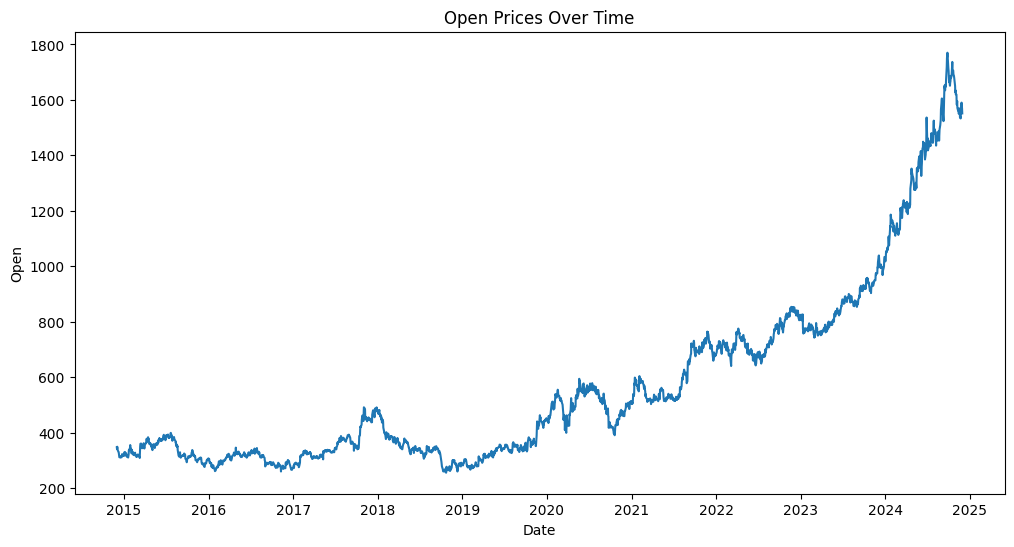

Training on device: cuda


/tmp/ipykernel_23/2376316169.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
/tmp/ipykernel_23/2376316169.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 0.0544, Val Loss = 0.5872
Epoch 2: Train Loss = 0.0074, Val Loss = 0.3021
Epoch 3: Train Loss = 0.0053, Val Loss = 0.2119
Epoch 4: Train Loss = 0.0049, Val Loss = 0.1285
Epoch 5: Train Loss = 0.0051, Val Loss = 0.1208
Epoch 6: Train Loss = 0.0048, Val Loss = 0.0508
Epoch 7: Train Loss = 0.0043, Val Loss = 0.0615
Epoch 8: Train Loss = 0.0047, Val Loss = 0.0959
Epoch 9: Train Loss = 0.0042, Val Loss = 0.0244
Epoch 10: Train Loss = 0.0041, Val Loss = 0.0580
Epoch 11: Train Loss = 0.0044, Val Loss = 0.0542
Epoch 12: Train Loss = 0.0035, Val Loss = 0.1340
Epoch 13: Train Loss = 0.0044, Val Loss = 0.0223
Epoch 14: Train Loss = 0.0042, Val Loss = 0.0351
Epoch 15: Train Loss = 0.0039, Val Loss = 0.0149
Epoch 16: Train Loss = 0.0041, Val Loss = 0.0204
Epoch 17: Train Loss = 0.0038, Val Loss = 0.0137
Epoch 18: Train Loss = 0.0031, Val Loss = 0.0244
Epoch 19: Train Loss = 0.0035, Val Loss = 0.0065
Epoch 20: Train Loss = 0.0036, Val Loss = 0.0685
Epoch 21: Train Loss = 0.0031

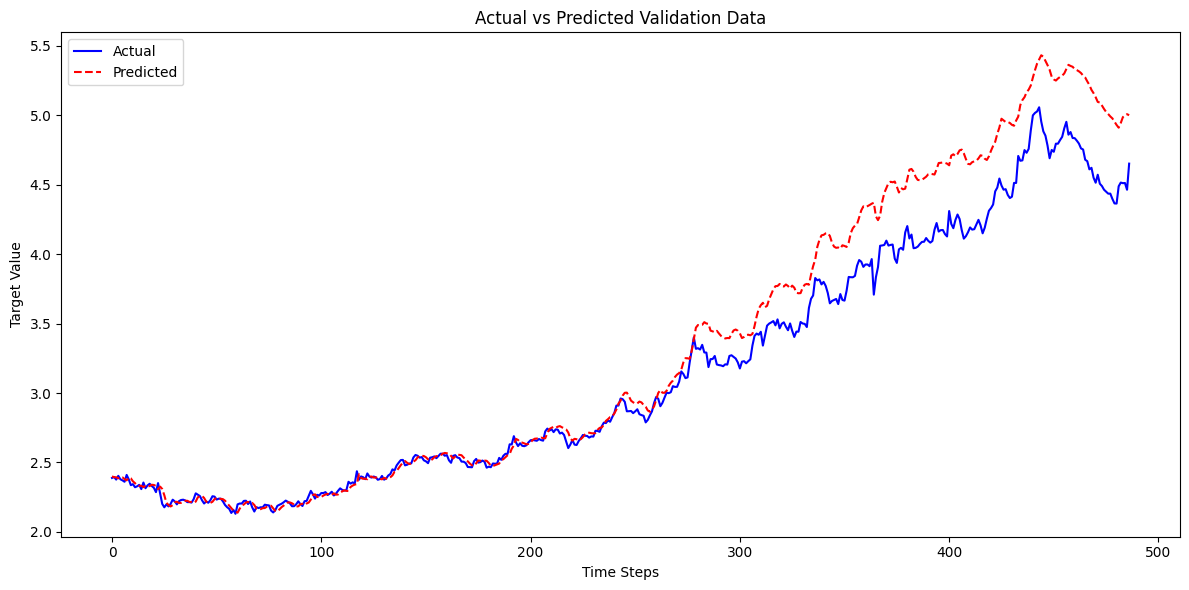

                Metric     Value
0   Mean Squared Error  0.072540
1  Mean Absolute Error  0.180855
2             R² Score  0.902740


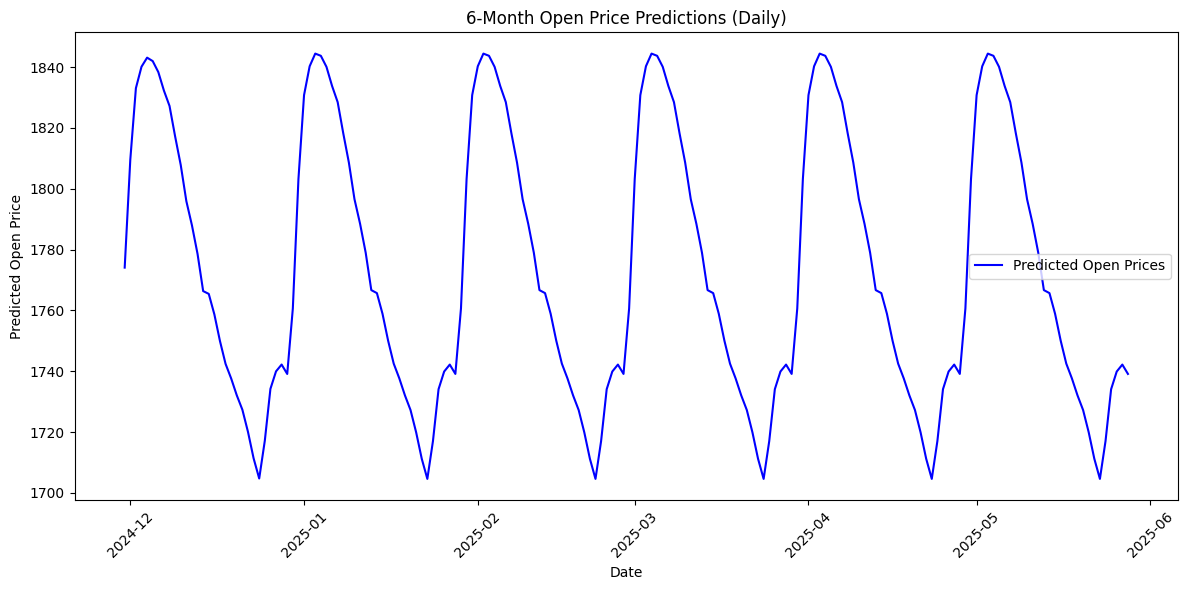

In [21]:
main(df_bharat, "bharat")

In [40]:
df_sbin = "/kaggle/input/sbin-data/sbin.csv"

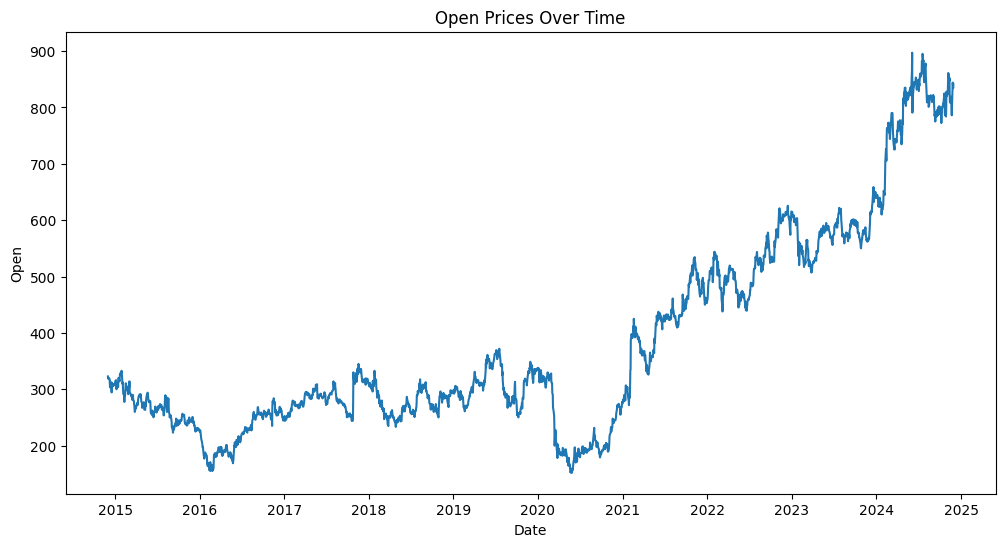

Training on device: cuda


/tmp/ipykernel_23/197765467.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
/tmp/ipykernel_23/197765467.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 0.1377, Val Loss = 0.4447
Epoch 2: Train Loss = 0.0191, Val Loss = 0.6050
Epoch 3: Train Loss = 0.0125, Val Loss = 0.2240
Epoch 4: Train Loss = 0.0119, Val Loss = 0.0722
Epoch 5: Train Loss = 0.0092, Val Loss = 0.1250
Epoch 6: Train Loss = 0.0104, Val Loss = 0.1485
Epoch 7: Train Loss = 0.0098, Val Loss = 0.0269
Epoch 8: Train Loss = 0.0100, Val Loss = 0.0680
Epoch 9: Train Loss = 0.0075, Val Loss = 0.1149
Epoch 10: Train Loss = 0.0088, Val Loss = 0.0359
Epoch 11: Train Loss = 0.0076, Val Loss = 0.0452
Epoch 12: Train Loss = 0.0076, Val Loss = 0.0735
Epoch 13: Train Loss = 0.0081, Val Loss = 0.0830
Epoch 14: Train Loss = 0.0079, Val Loss = 0.0362
Epoch 15: Train Loss = 0.0076, Val Loss = 0.1515
Epoch 16: Train Loss = 0.0071, Val Loss = 0.0261
Epoch 17: Train Loss = 0.0075, Val Loss = 0.0184
Epoch 18: Train Loss = 0.0069, Val Loss = 0.0733
Epoch 19: Train Loss = 0.0070, Val Loss = 0.0397
Epoch 20: Train Loss = 0.0067, Val Loss = 0.1104
Epoch 21: Train Loss = 0.0072

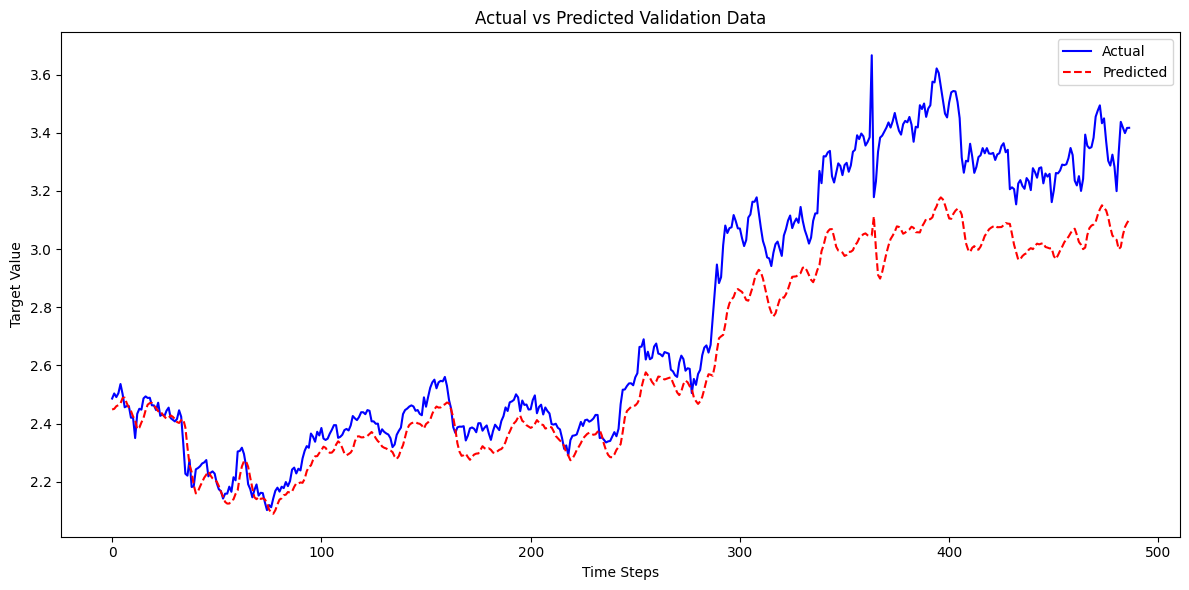

                Metric     Value
0   Mean Squared Error  0.038013
1  Mean Absolute Error  0.149889
2             R² Score  0.814196


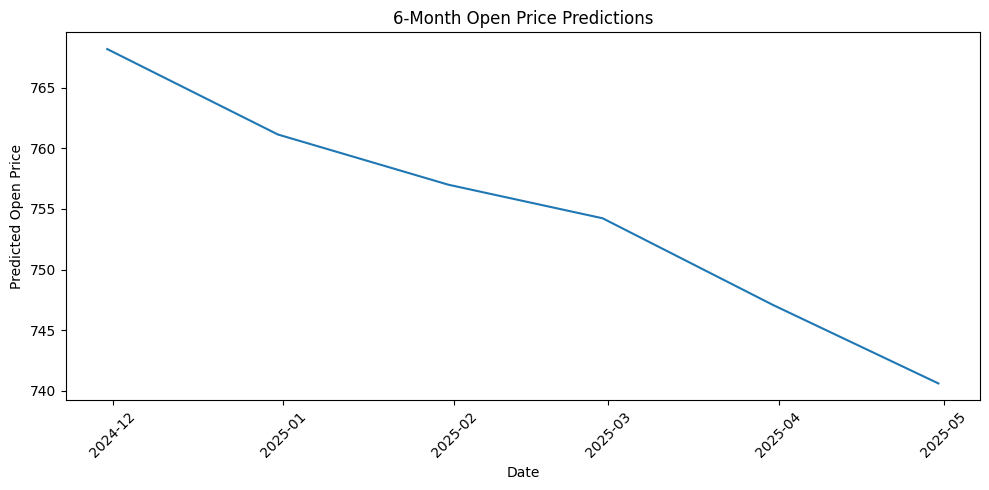

In [41]:
main(df_sbin, "sbin")

In [2]:
df_hindunilvr = "/kaggle/input/hindunilvr/hindunilvr.csv"

In [3]:
main(df_hindunilvr, "hindunilvr")

NameError: name 'main' is not defined

In [37]:
df_kotak = "/kaggle/input/kotak-bank/kotak.csv"

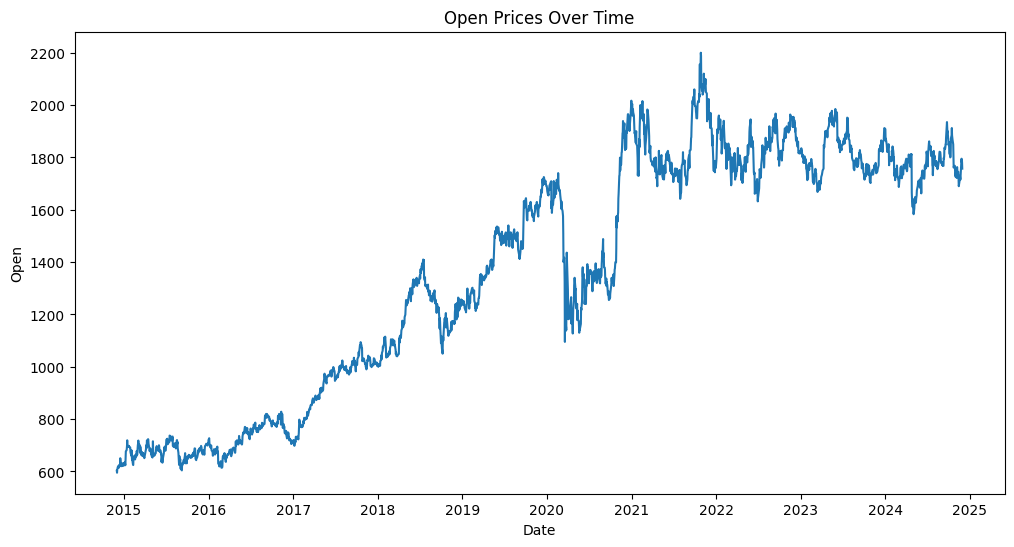

Training on device: cuda


/tmp/ipykernel_23/2376316169.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
/tmp/ipykernel_23/2376316169.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 0.1954, Val Loss = 0.0400
Epoch 2: Train Loss = 0.0289, Val Loss = 0.0095
Epoch 3: Train Loss = 0.0185, Val Loss = 0.0071
Epoch 4: Train Loss = 0.0151, Val Loss = 0.0109
Epoch 5: Train Loss = 0.0164, Val Loss = 0.0054
Epoch 6: Train Loss = 0.0150, Val Loss = 0.0090
Epoch 7: Train Loss = 0.0121, Val Loss = 0.0058
Epoch 8: Train Loss = 0.0121, Val Loss = 0.0055
Epoch 9: Train Loss = 0.0132, Val Loss = 0.0062
Epoch 10: Train Loss = 0.0110, Val Loss = 0.0059
Epoch 11: Train Loss = 0.0109, Val Loss = 0.0063
Epoch 12: Train Loss = 0.0105, Val Loss = 0.0045
Epoch 13: Train Loss = 0.0107, Val Loss = 0.0046
Epoch 14: Train Loss = 0.0109, Val Loss = 0.0044
Epoch 15: Train Loss = 0.0105, Val Loss = 0.0050
Epoch 16: Train Loss = 0.0111, Val Loss = 0.0090
Epoch 17: Train Loss = 0.0093, Val Loss = 0.0100
Epoch 18: Train Loss = 0.0108, Val Loss = 0.0042
Epoch 19: Train Loss = 0.0096, Val Loss = 0.0047
Epoch 20: Train Loss = 0.0123, Val Loss = 0.0039
Epoch 21: Train Loss = 0.0105

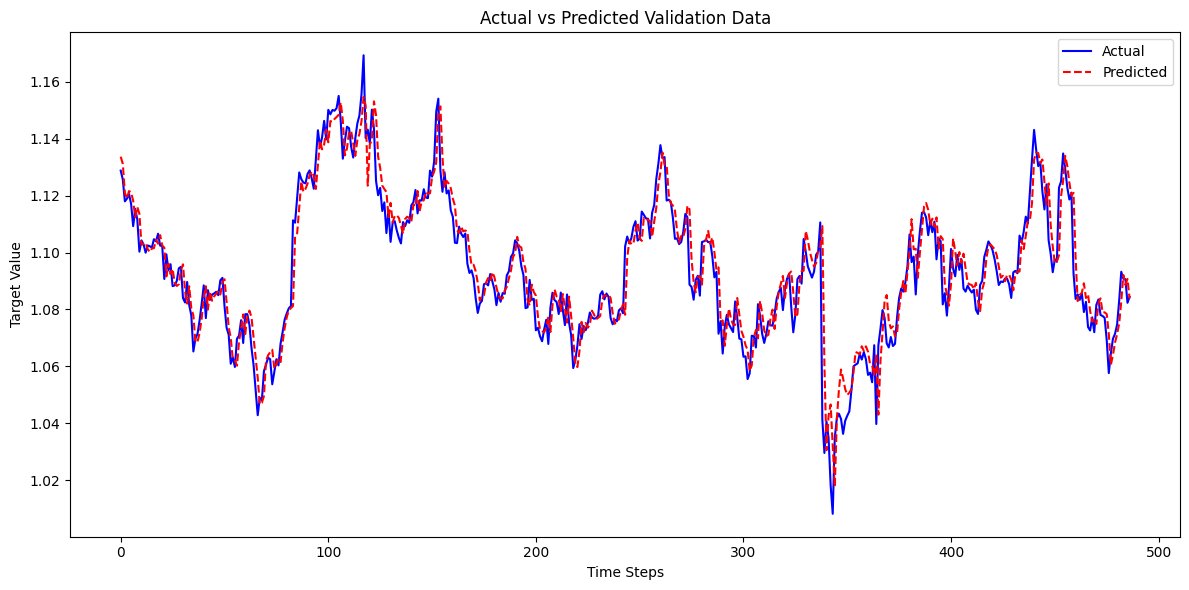

                Metric     Value
0   Mean Squared Error  0.000071
1  Mean Absolute Error  0.005955
2             R² Score  0.886270


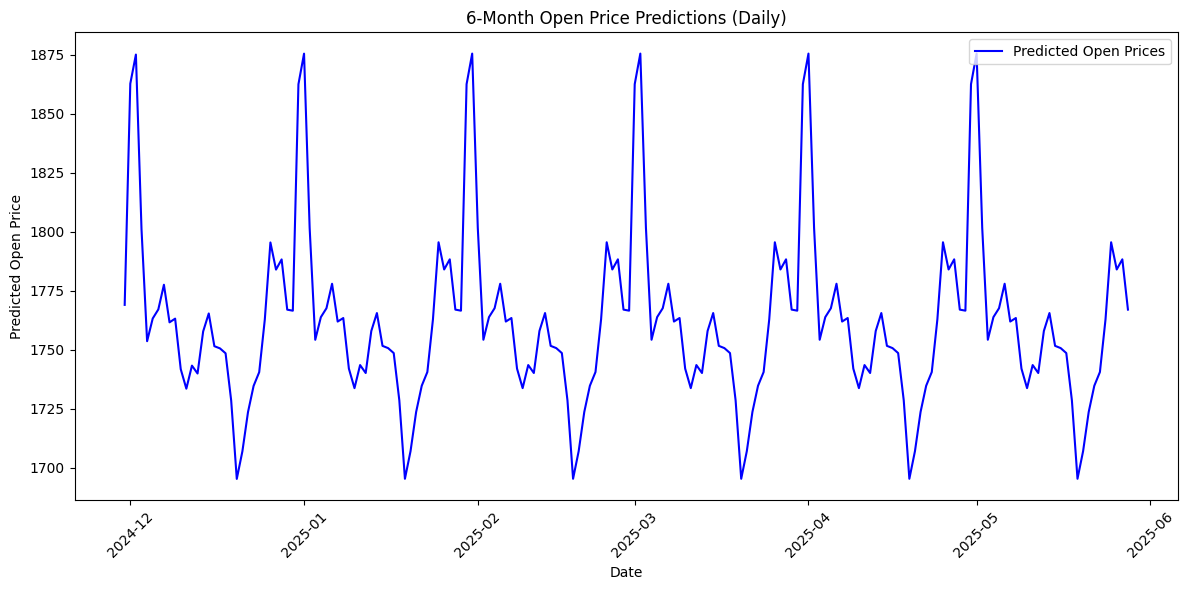

In [38]:
main(df_kotak, "kotak")

In [48]:
kotak_pred = "/kaggle/working/6_month_kotak_stock_predictions.csv"

In [49]:
df_kotak_pred = pd.read_csv(kotak_pred)

In [51]:
df_kotak_pred.head()

,Date,Open
0,2024-11-30,1758.998213
1,2024-12-31,1834.262251
2,2025-01-31,1868.754886
3,2025-02-28,1819.249640
4,2025-03-31,1754.457513
